<a href="https://colab.research.google.com/github/brendanpshea/database_sql/blob/main/Database_11_DesignDeployTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Database Architecture Patterns: Design, Deployment, and Testing for Modern Applications

### Database and SQL Through Pop Culture | Brendan Shea, PhD

Modern database systems require careful consideration of design patterns, deployment strategies, and testing methodologies. This chapter explores practical approaches to database architecture through an entertaining series of examples - from Springfield Nuclear Power Plant's data normalization challenges to Rick and Morty's interdimensional deployment decisions. We'll see how SpongeBob handles unit testing at the Krusty Krab, watch Brain and Pinky stress test their world-domination database, and learn why Wile E. Coyote needed flexible schema design at ACME Corporation.

After completing this chapter, you will be able to:

-   Apply key database design patterns to solve common architectural challenges
-   Evaluate and implement appropriate deployment models for different use cases
-   Design comprehensive testing strategies across unit, integration, and performance testing
-   Identify trade-offs between different architectural approaches
-   Troubleshoot common database architecture issues

The chapter combines theoretical foundations with practical examples, using familiar scenarios to illustrate complex concepts. Through Homer Simpson's database mishaps, Princess Carolyn's data security concerns, and Dexter's laboratory experiments, we'll explore how different architectural patterns solve real-world problems.

## Brendan's Lecture

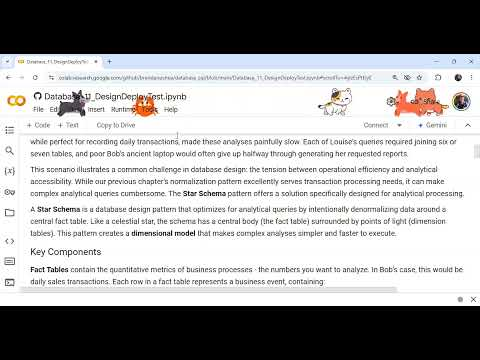

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('fLkjTZPn5q8', width=800, height=500)


## Introduction to Design Patterns
Database design patterns represent battle-tested solutions to recurring architectural challenges. These patterns have emerged from decades of practical experience across diverse applications and industries. While no pattern is universally applicable, understanding these common approaches helps architects make informed decisions when designing database systems. This section explores seven fundamental patterns through practical examples, examining their benefits, trade-offs, and implementation considerations.


## Normalize to 3NF: Brining Order to Chaos

Springfield Nuclear Power Plant's database system was a mess. Mr. Burns insisted on keeping all employee information in a single spreadsheet-like table, including employee details, their safety certifications, department assignments, and incident reports. Homer Simpson, surprisingly promoted to database administrator after a series of unfortunate events involving the previous DBA and a radioactive donut, faced numerous problems. When Lenny Leonard moved to a new address, Homer had to update the information in multiple rows. Worse, when Carl Carlson transferred departments, some of his records showed the old department while others showed the new one. This inconsistency led to chaos during safety inspections and payroll processing.

These problems exemplify the challenges of **data redundancy** - storing the same information in multiple places - and **data anomalies** - inconsistencies that arise when redundant data is updated incompletely. The normalization pattern addresses these fundamental database design challenges through a systematic approach to organizing data.

### Understanding Normalization

**Normalization** is a design pattern that progressively refines a database schema to minimize redundancy and maintain data integrity. It works by decomposing larger, problematic tables into smaller, well-structured ones, each focused on a specific aspect of the data. The process follows several formal steps called **normal forms**.

Let's examine how Homer could apply normalization to fix the power plant's database:

#### The Original Problem Table

| EmpID | Name | Address | Department | DeptLocation | Certification | CertExpiry | SupervisorName | SupervisorDept |
|-------|------|---------|------------|--------------|---------------|-------------|----------------|----------------|
| 1 | Homer Simpson | 742 Evergreen Terrace | Safety | Sector 7G | Nuclear Operations | 2024-06-15 | Mr. Burns | Executive |
| 1 | Homer Simpson | 742 Evergreen Terrace | Safety | Sector 7G | Donut Quality | 2024-08-01 | Mr. Burns | Executive |

This single table suffers from several issues:
- Employee information is repeated for each certification
- Department location is duplicated for each employee in that department
- Supervisor information is redundantly stored

### The Normalization Process

**First Normal Form (1NF)** requires that each column contains atomic (indivisible) values and that there are no repeating groups. Homer's first step was ensuring that each certification got its own row (which was already done) and that complex fields like address were broken down into their components.

**Second Normal Form (2NF)** eliminates partial dependencies on the primary key. In our case, the employee's name and address depend only on the EmpID, not on the certification, so they should be in a separate table.

**Third Normal Form (3NF)** removes transitive dependencies - when a non-key column depends on another non-key column. Department location depends on the department name, not directly on the employee, so it belongs in a separate departments table.

After applying these normalization rules, Homer transformed the power plant's database into a properly organized structure. This solved several problems:
- When employees move, their address only needs to be updated in one place
- Department information is stored once, eliminating inconsistencies
- Certification records can be added or removed without duplicating employee data

The resulting normalized structure is illustrated in the following entity-relationship diagram:

In [ ]:
# @title
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph, width=1000, height=700):  # Add default dimensions
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    # Add width and height parameters to the URL
    url = f"https://mermaid.ink/img/{base64_string}?width={width}&height={height}"
    display(Image(url=url))

mm("""
erDiagram
    EMPLOYEES ||--o{ EMPLOYEE_CERTIFICATIONS : has
    EMPLOYEES ||--o{ DEPARTMENT_ASSIGNMENTS : works_in
    DEPARTMENTS ||--o{ DEPARTMENT_ASSIGNMENTS : contains
    EMPLOYEES ||--o{ EMPLOYEES : supervises
    CERTIFICATIONS ||--o{ EMPLOYEE_CERTIFICATIONS : includes

    EMPLOYEES {
        int employee_id PK
        string first_name
        string last_name
        string street_address
        string city
        string state
        string zip_code
        int supervisor_id FK
    }

    DEPARTMENTS {
        int department_id PK
        string department_name
        string location
        string building_code
    }

    CERTIFICATIONS {
        int certification_id PK
        string certification_name
        string description
        int validity_period
    }

    EMPLOYEE_CERTIFICATIONS {
        int employee_id PK, FK
        int certification_id PK, FK
        date issue_date
        date expiry_date
        string status
    }

    DEPARTMENT_ASSIGNMENTS {
        int employee_id PK, FK
        int department_id PK, FK
        date start_date
        date end_date
        string role
    }
""")

## The Star Schema Pattern: Optimizing for Analysis

Bob Belcher's burger restaurant had a problem. His daughter Louise, the self-proclaimed "data wizard" of the family, wanted to analyze their business from every possible angle - daily sales by burger type, ingredient costs by supplier, customer preferences by time of day, seasonal trends, and even the impact of Jimmy Pesto's daily specials on their own sales. Their normalized database, while perfect for recording daily transactions, made these analyses painfully slow. Each of Louise's queries required joining six or seven tables, and poor Bob's ancient laptop would often give up halfway through generating her requested reports.

This scenario illustrates a common challenge in database design: the tension between operational efficiency and analytical accessibility. While our previous chapter's normalization pattern excellently serves transaction processing needs, it can make complex analytical queries cumbersome. The **Star Schema** pattern offers a solution specifically designed for analytical processing.

A **Star Schema** is a database design pattern that optimizes for analytical queries by intentionally denormalizing data around a central fact table. Like a celestial star, the schema has a central body (the fact table) surrounded by points of light (dimension tables). This pattern creates a **dimensional model** that makes complex analyses simpler and faster to execute.

### Key Components

**Fact Tables** contain the quantitative metrics of business processes - the numbers you want to analyze. In Bob's case, this would be daily sales transactions. Each row in a fact table represents a business event, containing:
- Numeric measures (quantity sold, price, cost)
- Foreign keys to dimension tables
- The lowest level of granularity needed for analysis

**Dimension Tables** contain the descriptive attributes that give context to the facts. They answer the who, what, where, when, and why of your data. For Bob's Burgers, dimensions include:
- Time (date, day of week, month, season)
- Product (burger name, category, ingredients)
- Customer (type, frequency, preferences)
- Location (table number, section, inside/outside)

### From Normalized to Star: Bob's Transformation

Let's see how Louise restructured their database. Originally, they had normalized tables for orders, menu items, ingredients, customers, and transactions. Louise created a star schema for analysis while keeping the normalized structure for daily operations:

The burger sales fact table records each sale with measures like:
- Quantity sold
- Sale price
- Food cost
- Preparation time
- Profit margin

Dimension tables provide rich context:
- Date dimension includes daily weather, local events, and whether Jimmy Pesto was running a competing special
- Product dimension categorizes burgers by type, ingredients, and the "Burger of the Day" status
- Customer dimension tracks diner preferences and visit patterns
- Time-of-day dimension segments the day into breakfast, lunch, dinner, and late-night periods

This structure allowed Louise to easily answer questions like "What burgers sell best on rainy days?" or "How do Jimmy Pesto's promotions affect our sales of similar items?"

In [ ]:
# @title
mm("""

erDiagram
    SALES_FACT ||--o{ DIM_DATE : when
    SALES_FACT ||--o{ DIM_PRODUCT : what
    SALES_FACT ||--o{ DIM_CUSTOMER : who
    SALES_FACT ||--o{ DIM_TIME : "what time"

    SALES_FACT {
        int sale_id PK
        int date_key FK
        int product_key FK
        int customer_key FK
        int time_key FK
        decimal sale_amount
        int quantity
        decimal food_cost
        decimal profit_margin
        int prep_time_minutes
    }

    DIM_DATE {
        int date_key PK
        date full_date
        string day_of_week
        string month_name
        string season
        boolean is_holiday
        string weather_type
        boolean pesto_promotion_day
    }

    DIM_PRODUCT {
        int product_key PK
        string burger_name
        string category
        boolean is_burger_of_day
        string special_ingredients
        decimal base_price
        string spice_level
    }

    DIM_CUSTOMER {
        int customer_key PK
        string type
        string frequency_category
        string preferred_seating
        boolean regular_status
    }

    DIM_TIME {
        int time_key PK
        string time_period
        string meal_category
        boolean peak_hours
        string shift_period
    }
""")


After implementing this star schema, Louise's analytical queries became significantly faster. Bob could now quickly identify their most profitable "Burger of the Day" creations, understand how weather affects outdoor seating preferences, and optimize their ingredient ordering based on seasonal patterns. The family could make data-driven decisions about staffing, inventory, and special promotions, all while Gene made questionable musical puns about database joins.

The star schema pattern shines brightest in analytical scenarios, but it comes with trade-offs. It introduces some data redundancy and isn't suitable for transaction processing. This is why many businesses, like Bob's Burgers, maintain both normalized operational databases and denormalized analytical star schemas, often using ETL (Extract, Transform, Load) processes to move data between them.

In our next section, we'll explore how to handle many-to-many relationships using the Bridge Tables pattern, illustrated through the complex web of relationships in South Park Elementary's school management system.

## The Bridge Tables Pattern: Managing Many-to-Many Relationships

Principal Victoria of South Park Elementary faced a database dilemma. Mr. Garrison kept complaining that the school's system couldn't properly track which students were in which classes, who participated in which extracurricular activities, or which parents belonged to which PTA committees. The existing database forced them to list multiple classes in a single student record, creating a maintenance nightmare when Cartman decided to switch from Music to Art class mid-semester, or when Kenny's frequent absences (and resurrections) needed to be recorded.

This scenario illustrates a common challenge in database design: managing **many-to-many relationships**. In real-world systems, entities often have complex relationships where multiple instances of one type can relate to multiple instances of another type. A student can enroll in many classes, and each class has many students. A parent can join multiple PTA committees, and each committee has multiple parents.

A **Bridge Table** (also known as a **junction table** or **association table**) is a design pattern that resolves many-to-many relationships by creating an intermediate table that connects two entities. This table contains foreign keys to both parent tables and often includes additional attributes about the relationship itself.

### Anatomy of a Bridge Table

A well-designed bridge table typically contains:
- Foreign keys to both parent tables
- A composite primary key consisting of both foreign keys
- Additional columns describing the relationship
- Optional temporal information about the relationship

### South Park Elementary's Solution

Let's examine how the school implemented bridge tables to solve their various many-to-many relationships:

**Student-Class Relationships**
Instead of trying to cram multiple class assignments into the student record, the school created a bridge table called "enrollments" that tracks:
- Which student is in which class
- When they enrolled
- Their current grade
- Attendance records
- Assignment completion status

**Parent-Committee Relationships**
The PTA committee system uses a bridge table to track:
- Which parents serve on which committees
- Their roles within each committee
- Term dates
- Participation metrics
- Contact preferences

**Student-Activity Relationships**
Extracurricular activities are managed through a bridge table recording:
- Which students participate in which activities
- Permission slip status
- Equipment assignments
- Achievement badges
- Parent volunteer commitments

This approach solved multiple problems:
1. When Cartman switched classes, only one record in the enrollments table needed to be updated
2. Kenny's attendance could be tracked per class without affecting his basic student record
3. Mr. Garrison could easily generate reports showing class rosters and student participation
4. The PTA could maintain clear records of committee membership and participation

The following entity-relationship diagram illustrates the bridge table pattern in action at South Park Elementary:

In [ ]:
# @title
mm("""

erDiagram
    STUDENTS ||--o{ ENROLLMENTS : enrolls
    CLASSES ||--o{ ENROLLMENTS : contains
    STUDENTS ||--o{ ACTIVITY_PARTICIPANTS : participates
    ACTIVITIES ||--o{ ACTIVITY_PARTICIPANTS : includes
    PARENTS ||--o{ COMMITTEE_MEMBERS : serves
    COMMITTEES ||--o{ COMMITTEE_MEMBERS : staffed_by
    STUDENTS ||--o{ STUDENT_PARENTS : has
    PARENTS ||--o{ STUDENT_PARENTS : of

    STUDENTS {
        int student_id PK
        string first_name
        string last_name
        int grade_level
        string homeroom
        date enrollment_date
    }

    CLASSES {
        int class_id PK
        string subject
        string teacher
        int room_number
        string semester
        int max_capacity
    }

    ENROLLMENTS {
        int student_id PK,FK
        int class_id PK,FK
        date enroll_date
        string grade
        int attendance_count
        string status
    }

    ACTIVITIES {
        int activity_id PK
        string name
        string supervisor
        string meeting_time
        string location
        int max_participants
    }

    ACTIVITY_PARTICIPANTS {
        int student_id PK,FK
        int activity_id PK,FK
        date join_date
        boolean permission_slip
        string role
        string achievement_level
    }

    PARENTS {
        int parent_id PK
        string first_name
        string last_name
        string contact_info
        boolean background_check
    }

    COMMITTEES {
        int committee_id PK
        string name
        string purpose
        string meeting_schedule
        int budget
    }

    COMMITTEE_MEMBERS {
        int parent_id PK,FK
        int committee_id PK,FK
        date join_date
        string role
        boolean voting_rights
        int term_length
    }

    STUDENT_PARENTS {
        int student_id PK,FK
        int parent_id PK,FK
        string relationship
        boolean primary_contact
        boolean emergency_contact
    }
""")


The bridge table pattern brought order to South Park Elementary's database chaos. Mr. Garrison could now easily track student participation, Principal Victoria could generate accurate reports for the school board, and even Cartman couldn't find a way to manipulate the system (though not for lack of trying).

While bridge tables add complexity to the database schema, they provide a robust solution for managing many-to-many relationships. They maintain data integrity while providing flexibility to store relationship-specific attributes. In our next section, we'll explore how to handle changes over time using the Temporal Pattern, illustrated through Professor Farnsworth's problematic employee database at Planet Express.

## The Temporal Pattern: Tracking Changes Through Time

"Good news, everyone!" Professor Farnsworth announced to the Planet Express crew. "I've discovered that our employee database is completely wrong about everyone's historical salary data, job titles, and delivery routes!" This was, of course, not actually good news. The Professor's database only stored current information, overwriting history with each update. When the Space Tax Bureau audited their records, they couldn't explain why Fry's salary had supposedly jumped from $0.01 to $100.00 per minute (a computer glitch that Dr. Zoidberg had accidentally caused while eating a sandwich over the keyboard).

This scenario illustrates a common database challenge: maintaining the history of changes over time. Many systems only store the current state of data, but business needs often require tracking how data changes: employee salaries over time, customer address histories, product price changes, or the evolution of delivery routes through dangerous space nebulae.

### Understanding Temporal Data

**Temporal data** refers to information that is time-dependent, where maintaining historical accuracy is crucial. The **Temporal Pattern** provides strategies for tracking changes to data over time, ensuring that historical information is preserved while maintaining current operational needs.

**Effective Dating** uses date ranges to indicate when a particular record is valid:
- **Effective Start Date**: When a record becomes valid
- **Effective End Date**: When a record ceases to be valid
- **Current Flag**: Optional boolean indicating if this is the current record

**Temporal Types** can include:
- **Valid Time**: When something was true in the real world
- **Transaction Time**: When something was recorded in the database
- **Bi-temporal**: Tracking both valid and transaction time

Let's see how Planet Express implemented temporal patterns to track various aspects of their business:

### Employee History Tracking

Instead of simply storing current employee information, Planet Express created temporal tables to track changes in:
- Salary history
- Job title changes
- Department assignments
- Employee status (alive, dead, temporarily dead, roboticized)

For example, Fry's salary history might look like:

| Employee | Salary | Effective_Start | Effective_End | Current |
|----------|--------|-----------------|---------------|---------|
| Fry | \$0.05/min | 2999-12-31 | 3001-06-15 | False |
| Fry | \$0.01/min | 3001-06-16 | 3001-06-16 | False |
| Fry | \$100.00/min | 3001-06-17 | 3001-06-17 | False |
| Fry | \$0.10/min | 3001-06-18 | NULL | True |

Planet Express also needed to track:
- Historical delivery routes and their risk levels
- Changes in route pricing
- Temporal variations in space-time anomalies
- Customer location changes across dimensional rifts

The following entity-relationship diagram illustrates how Planet Express implemented their temporal tracking system:

In [ ]:
# @title
mm("""

erDiagram
    EMPLOYEES ||--o{ EMPLOYEE_HISTORY : has
    EMPLOYEES ||--o{ SALARY_HISTORY : earns
    EMPLOYEES ||--o{ POSITION_HISTORY : holds
    DELIVERY_ROUTES ||--o{ ROUTE_HISTORY : changes
    DELIVERY_ROUTES ||--o{ PRICE_HISTORY : costs

    EMPLOYEES {
        int employee_id PK
        string name
        string species
        date hire_date
        boolean is_robot
    }

    EMPLOYEE_HISTORY {
        int history_id PK
        int employee_id FK
        string status
        datetime effective_start
        datetime effective_end
        boolean is_current
        datetime system_start
        datetime system_end
    }

    SALARY_HISTORY {
        int history_id PK
        int employee_id FK
        decimal salary_amount
        string salary_unit
        datetime effective_start
        datetime effective_end
        boolean is_current
        string change_reason
    }

    POSITION_HISTORY {
        int history_id PK
        int employee_id FK
        string job_title
        string department
        datetime effective_start
        datetime effective_end
        boolean is_current
        string change_reason
    }

    DELIVERY_ROUTES {
        int route_id PK
        string route_name
        string start_location
        string end_location
        int danger_level
    }

    ROUTE_HISTORY {
        int history_id PK
        int route_id FK
        geometry path_coordinates
        int space_time_risk
        datetime effective_start
        datetime effective_end
        boolean is_current
        string change_reason
    }

    PRICE_HISTORY {
        int history_id PK
        int route_id FK
        decimal base_price
        decimal danger_multiplier
        datetime effective_start
        datetime effective_end
        boolean is_current
        string change_reason
    }
""")


This temporal design solved numerous problems for Planet Express:
1. The Space Tax Bureau could now audit accurate historical salary records
2. Professor Farnsworth could analyze how delivery route changes affected efficiency
3. Hermes could track employee status changes (particularly useful for crew members who frequently died and returned)
4. The company could maintain accurate pricing histories for different temporal zones

### Implementation Considerations

The temporal pattern introduces several important considerations:
- Historical records significantly increase *storage needs*
- Temporal queries require careful handling of date ranges, and more complex queries
- Maintaining history can affect *insert and update performance*
- *Data Retention Policies* must be established for how long to keep historical data
- *Temporal Consistency* requires ensuring that time periods don't overlap or leave gaps

For instance, Planet Express had to carefully handle scenarios where timeline alterations affected historical records, or when Fry became his own grandfather. These edge cases were resolved by implementing specialized temporal consistency checks and paradox detection algorithms.

The temporal pattern, while adding complexity to database design, provides crucial capabilities for businesses operating across time (or multiple dimensions, in Planet Express's case). In our next section, we'll explore how to handle inheritance hierarchies using the Polymorphic Associations Pattern, illustrated through the diverse character types in Professor Oak's Pokémon research database.

## The Polymorphic Associations Pattern: When Things Need to Connect to Many Types of Other Things

Professor Oak faced a unique challenge in his Pokémon Research Database. His researchers needed to track all sorts of different interactions: Pokémon could belong to Trainers or live in the wild, Items could be held by either Pokémon or Trainers, and Battles could involve Wild Pokémon, Trainer Pokémon, or Gym Leaders' Pokémon. Every time they discovered a new type of interaction (like Pokémon watching TV shows), the database needed significant changes.

### The Problem with Simple Relationships

Initially, Oak's team tried creating separate tables for each type of relationship. Here's what they had:

**TRAINER_POKEMON**

| trainer_id | pokemon_id | nickname | catch_date |
|------------|------------|----------|------------|
| 1 | 25 | Sparky | 2024-01-15 |
| 1 | 6 | Flamey | 2024-02-01 |

**WILD_POKEMON**

| pokemon_id | location_id | last_seen_date |
|------------|-------------|----------------|
| 147 | 23 | 2024-03-20 |
| 149 | 23 | 2024-03-21 |

**TRAINER_ITEMS**

| trainer_id | item_id | quantity | acquire_date |
|------------|---------|----------|--------------|
| 1 | 1 | 5 | 2024-03-01 |
| 2 | 2 | 1 | 2024-03-15 |

**POKEMON_ITEMS**

| pokemon_id | item_id | acquire_date |
|------------|---------|--------------|
| 25 | 3 | 2024-03-10 |
| 6 | 4 | 2024-03-12 |

This approach quickly became unwieldy. When they wanted to add TV Show watching, they'd need yet another table. Querying was complicated too - finding all holders of a particular item required checking multiple tables.

### The Polymorphic Solution

Instead of creating new tables for each relationship type, Oak's team implemented a polymorphic design that could handle any type of relationship:

**ENTITIES**

| entity_id | type | name |
|-----------|------|------|
| 1 | trainer | Ash |
| 2 | pokemon | Pikachu |
| 3 | item | Poké Ball |
| 4 | location | Viridian Forest |
| 5 | tv_show | Pokémon Watch |

**RELATIONSHIPS**

| id | from_entity_id | relationship_type | to_entity_id | started_at |
|-------|----------------|------------------|--------------|------------|
| 1 | 1 | owns | 2 | 2024-01-15 |
| 2 | 2 | holds | 3 | 2024-03-10 |
| 3 | 2 | watches | 5 | 2024-03-24 |

**RELATIONSHIP_ATTRIBUTES**

| relationship_id | attribute | value |
|----------------|-----------|--------|
| 1 | nickname | Sparky |
| 2 | duration_minutes | 30 |
| 3 | enjoyment_level | high |

This new design could handle any type of relationship between any entities in the system. When they discovered that Pokémon enjoyed watching TV shows, they simply added new relationships rather than modifying the database structure.

Here's how the whole system fits together:

In [ ]:
# @title
mm("""

erDiagram
    ENTITIES ||--o{ RELATIONSHIPS : "participates in"
    ENTITIES ||--o{ ENTITY_ATTRIBUTES : "has"
    RELATIONSHIPS ||--o{ RELATIONSHIP_ATTRIBUTES : "has"

    ENTITIES {
        int entity_id PK
        string type
        string name
        datetime created_at
    }

    RELATIONSHIPS {
        int relationship_id PK
        int from_entity_id FK
        string relationship_type
        int to_entity_id FK
        datetime started_at
        datetime ended_at
    }

    RELATIONSHIP_ATTRIBUTES {
        int relationship_id FK
        string attribute
        string value
    }

    ENTITY_ATTRIBUTES {
        int entity_id FK
        string attribute
        string value
    }
""")

This solution made everything much more flexible. When Professor Oak's team discovered that Pokémon could form friendships with inanimate objects (like Pikachu's fondness for ketchup bottles), they just added new relationships rather than creating new tables. The database structure stayed the same, even as they discovered more about the complex world of Pokémon interactions.

The trade-off? Queries became a bit more complex, and they had to be more careful about data validation. But the flexibility of being able to add new types of relationships without database changes proved invaluable in their ever-evolving research.experimental data management system.

## The Partitioning Pattern: When Tables Get Too Big

"Dee Dee, get out of my laboratory database!" Young genius Dexter's frustration wasn't just with his sister's physical interruptions. His research database, containing billions of experimental measurements, was becoming impossibly slow. Queries that once took milliseconds now took hours. Backing up data required multiple robotic assistants working in shifts. Worse still, when Dee Dee's dance recital videos accidentally got mixed into his particle accelerator results table, purging them brought the entire system to a halt.

### The Problem with Big Tables

Imagine if every book in the library was just one enormous scroll instead of being divided into separate books. Finding anything would require unrolling the whole scroll! That's basically what was happening in Dexter's database. His main experiments table had grown to billions of rows:

**EXPERIMENTS table**

| experiment_id | timestamp | experiment_type | temperature | pressure | voltage | results |
|--------------|-----------|-----------------|-------------|----------|----------|----------|
| 1 | 2024-03-24 09:00 | particle_accel | 295.2 | 1.013 | 1000000 | [binary] |
| 2 | 2024-03-24 09:15 | quantum_tunnel | 2.1 | 0.001 | 500000 | [binary] |
| ... | ... | ... | ... | ... | ... | ... |
| (billions of rows) |

### The Partitioning Solution

**Partitioning** is a way to split huge tables into smaller, more manageable pieces that still act like one logical table. It's like how a library divides books across multiple shelves and floors, but still has one catalog system to find everything.

Dexter implemented two main types of partitioning:

#### 1. Range Partitioning by Date

The experiments table was split into monthly chunks:

**EXPERIMENTS_2024_03** (March experiments only)

| experiment_id | timestamp | experiment_type | temperature | pressure |
|--------------|-----------|-----------------|-------------|----------|
| 1001 | 2024-03-01 09:00 | particle_accel | 295.2 | 1.013 |
| 1002 | 2024-03-01 10:15 | quantum_tunnel | 2.1 | 0.001 |

**EXPERIMENTS_2024_02**
(February experiments only)

| experiment_id | timestamp | experiment_type | temperature | pressure |
|--------------|-----------|-----------------|-------------|----------|
| 901 | 2024-02-28 09:00 | particle_accel | 295.0 | 1.012 |
| 902 | 2024-02-28 10:15 | quantum_tunnel | 2.0 | 0.001 |

#### 2. List Partitioning by Type

For sensor readings, Dexter partitioned by the type of measurement:

**TEMPERATURE_READINGS**

| reading_id | experiment_id | value | timestamp |
|------------|---------------|-------|-----------|
| 1 | 1001 | 295.2 | 2024-03-01 09:00 |
| 2 | 1002 | 2.1 | 2024-03-01 10:15 |

**PRESSURE_READINGS**

| reading_id | experiment_id | value | timestamp |
|------------|---------------|-------|-----------|
| 1 | 1001 | 1.013 | 2024-03-01 09:00 |
| 2 | 1002 | 0.001 | 2024-03-01 10:15 |

The beauty of this approach is that it's transparent to users. Dexter's applications could still treat these as single logical tables called EXPERIMENTS and SENSOR_READINGS. The database handles all the complexity of figuring out which partition to query.

Here's how the whole system fits together:

In [ ]:
# @title
mm("""

erDiagram
    EXPERIMENTS ||--o{ SENSOR_READINGS : generates
    EXPERIMENTS ||--|{ EXPERIMENTS_BY_MONTH : "partitioned by date"
    SENSOR_READINGS ||--|{ READINGS_BY_TYPE : "partitioned by type"

    EXPERIMENTS_BY_MONTH {
        partition March_2024
        partition February_2024
        partition January_2024
        partition December_2023
    }

    READINGS_BY_TYPE {
        partition Temperature
        partition Pressure
        partition Voltage
        partition Radiation
    }
""")


This solution made everything work better. When Dexter needed recent experiment data, the database only had to search the current month's partition. When Dee Dee's dance videos needed to be purged, Dexter could take just that partition offline. Different types of data could use different storage settings - recent experiments on fast storage, old ones on slower, cheaper storage.

Even when accidents happened (like the time Dee Dee's ballet shoes ended up in the particle accelerator), the damage was contained to specific partitions. The database kept running, experiments continued, and Dexter could fix the affected partition without shutting down his entire laboratory.


## Hybrid Relational-JSON: Balancing Structure and Flexibility

Wile E. Coyote, freshly promoted (and slightly scorched) as ACME Corporation’s database administrator, faced a daunting challenge. ACME’s product catalog ranged from explosive TNT to giant rubber bands and spring-loaded anvil launchers. Each product type had unique attributes: TNT required fields for explosion radius and fuse length, while rubber bands needed flexibility ratings and stretch distance. Every new invention forced Wile E. to overhaul the database structure, leaving him tangled in complexity as absurd as one of his traps for the Road Runner.

### The Problem: Fixed Columns for a Diverse Catalog

Initially, ACME used a conventional relational database design. Each product had its attributes represented as fixed columns in the `PRODUCTS` table:

| **product_id** | **name**        | **category_id** | **base_price** | **weight** | **explosion_radius** | **fuse_length** | **stretch_distance** | **flexibility_rating** |
|-----------------|-----------------|-----------------|----------------|------------|-----------------------|-----------------|-----------------------|------------------------|
| TNT-123         | Deluxe TNT      | 1               | 99.99          | 5.0        | 50                    | 10              | null                 | null                  |
| RBD-456         | Giant Rubber    | 2               | 149.99         | 2.0        | null                 | null            | 100                  | 95                    |
| ANV-789         | Mega Anvil      | 3               | 299.99         | 500.0      | null                 | null            | null                 | null                  |

This approach quickly became unmanageable:
- **Sparsity**: Many columns were irrelevant (and empty) for certain products.
- **Rigid Structure**: Adding new product types required altering the database schema, creating a constant maintenance burden.
- **Scalability Issues**: The structure didn’t accommodate ACME’s growing catalog of bizarre products.

For Wile E., this was like trying to catch the Road Runner with a spoon—possible in theory, but inefficient and impractical.

### The Hybrid Solution: Combining Relational Data with JSON

ACME reimagined their database structure by blending the strengths of relational databases and JSON’s flexibility. Core product data, shared by all items, stayed in relational format. Specialized attributes unique to each product were moved to a single JSON column.

The *relational* part of the database stores universal attributes like product ID, name, category, base price, and weight:

| **product_id** | **name**        | **category_id** | **base_price** | **weight** |
|-----------------|-----------------|-----------------|----------------|------------|
| TNT-123         | Deluxe TNT      | 1               | 99.99          | 5.0        |
| RBD-456         | Giant Rubber    | 2               | 149.99         | 2.0        |
| ANV-789         | Mega Anvil      | 3               | 299.99         | 500.0      |

A single `attributes` column in JSON format now holds product-specific characteristics:

| **product_id** | **attributes**                                               |
|-----------------|-------------------------------------------------------------|
| TNT-123         | {"explosion_radius": 50, "fuse_length": 10}                 |
| RBD-456         | {"stretch_distance": 100, "flexibility_rating": 95}         |
| ANV-789         | {"impact_force": 1000, "drop_speed": 200}                   |


To maintain some structure and support validation, a `CATEGORIES` table lists which attributes are relevant for each product category:

| **id** | **name**       | **parent_id** | **allowed_attributes**                                   |
|--------|----------------|---------------|---------------------------------------------------------|
| 1      | Explosives     | null          | ["explosion_radius", "fuse_length", "safety_rating"]    |
| 2      | Elastics       | null          | ["stretch_distance", "flexibility_rating"]             |
| 3      | Heavy          | null          | ["impact_force", "drop_speed"]                         |

This setup allowed Wile E. to simply add new categories and attributes without altering the database schema. For example, ACME’s new "Portable Black Hole" products required attributes like `gravitational_pull` and `space_time_distortion_radius`. These were easily integrated into the system by updating the `CATEGORIES` table and storing new product attributes in JSON format.

In [ ]:
# @title
mm("""
erDiagram
    CATEGORIES ||--o{ PRODUCTS : contains
    CATEGORIES ||--o{ CATEGORIES : has_parent

    CATEGORIES {
        int id
        string name
        int parent_id
        json allowed_attributes
    }

    PRODUCTS {
        string product_id
        string name
        int category_id
        decimal base_price
        decimal weight
        json attributes
    }
""")


This design helped ACME manage their ever-growing catalog of improbable products while maintaining the benefits of a relational database. Even when they introduced their new "Quantum Tunnel Paint" (warning: may cause temporary existence in multiple dimensions simultaneously), adding the product was as simple as inserting a new row with the appropriate JSON attributes.

The trade-off? You need to be a bit more careful about validating the JSON data since the database can't enforce constraints on it like it can with regular columns. But for ACME's wildly varied inventory, the flexibility was worth it. After all, when your product catalog includes everything from spring-loaded pogo sticks to portable tornadoes, you need a database that can handle anything!


## Database Deployment Models: Choosing Your Data's Home

"Morty, *burp* Morty! The Council of Ricks hacked our database again!" Rick frantically unplugged servers in his garage while liquid started oozing from a nearby portal. "They got into our local servers, our cloud backups, everything! This is why we need to talk about database deployment models, Morty!"

"Oh geez Rick, what does that even mean?" Morty watched as Rick drew on his whiteboard, trying to explain where their interdimensional research data should live.

"Listen up, Morty, because I'm only explaining this *burp* once. There are three ways we can store our data, and they each have their own stupid problems:"

### The Three Deployment Models

1. **On-Premises** (Rick calls it "Paranoid Mode")
   - Your own servers in your own facility
   - Complete control over everything
   - Like keeping your portal gun recipes in the garage
   - "Sure, you maintain everything yourself, but at least when something goes wrong, you know exactly who to blame - yourself!"

2. **Cloud** (Rick calls it "Lazy Mode")
   - Your data on someone else's computers
   - Accessed over the internet
   - Like storing your Meeseeks box instructions on Amazon's servers
   - "Real convenient Morty, until Jeff Bezos decides to peek at our interdimensional cable channel listings!"

3. **Hybrid** (Rick calls it "Hedging Your Bets Mode")
   - Some data local, some in the cloud
   - Best of both worlds... or worst, depending on your luck
   - Like keeping dangerous formulas local but putting Mr. Poopybutthole's family photos in the cloud
   - "It's like having two things to worry about instead of one! *burp* Efficient!"

In [ ]:
# @title
mm("""

flowchart TD
    A[Need to Store Data] --> B{Control vs Convenience?}
    B -->|"Maximum Control"| C[On-Premises]
    B -->|"Maximum Convenience"| D[Cloud]
    B -->|"Both"| E[Hybrid]

    C --> F{Willing to Handle?}
    F -->|Yes| G[Maintenance]
    F -->|Yes| H[Security]
    F -->|Yes| I[Backups]

    D --> J{Can you Trust?}
    J -->|Yes| K[Provider Security]
    J -->|Yes| L[Uptime]
    J -->|Yes| M[Costs]

    E --> N{Can you Manage?}
    N -->|Yes| O[Complex Architecture]
    N -->|Yes| P[Data Sync]
    N -->|Yes| Q[Multiple Systems]
""")


Rick stumbled over to his workbench, grabbing his flask. "See Morty, choosing a deployment model is like choosing which dimension to live in. On-premises is like dimension C-137 - it's home, you know it, but maintaining it is a pain. Cloud is like the dimension where everyone sits on chairs - seems comfy until you realize someone else controls all the chairs. And hybrid? That's like being a time-traveling snake, Morty. *burp* You're everywhere and nowhere at once."

"But which one should we choose, Rick?"

"That's the thing, Morty. It depends on what we care about most:
- On-premises if you're paranoid about control (like me)
- Cloud if you're lazy and rich (like Jerry)
- Hybrid if you can't make up your mind (like Morty in literally every adventure)"

Just then, a portal opened and another Rick stepped through. "Hey, C-137! Your cloud provider just leaked our interdimensional cable subscription list!"

"See Morty? This is why we keep the really sensitive stuff in the garage. Now help me reinstall Linux on these servers before the Federation finds our Szechuan sauce recipe."


## On-Premises: Your Data at Home

"Bojack, I just got off the phone with the publisher," Princess Carolyn paced around her office at VIM. "They want to store your tell-all autobiography data on their cloud servers. I told them absolutely not - we're keeping everything on-premises after what happened with Sarah Lynn's ghostwriter leaks."

"But PC, what does 'on-premises' even mean?" Bojack slumped deeper into his chair, nursing his usual morning bourbon. "Is that like when Mr. Peanutbutter kept all his game show ideas written on tennis balls in his basement?"

**On-premises** (or **"on-prem"** if you're too busy being a Hollywoo star to say the whole thing) means keeping your data and servers physically in your own facility. At VIM, this meant:

- A dedicated server room in the basement of Bojack's mansion
- Their own hardware and infrastructure
- Complete control over security and access
- Todd somehow ending up as the system administrator ("Hooray! Root access!")

"Think of it like your house, Bojack," Princess Carolyn explained. "Instead of renting an apartment where the landlord controls everything, you own the place and handle all the maintenance yourself. Sure, it's more work, but at least when things go wrong, you know exactly who to blame."

"So... like always, blame Todd?" Bojack watched as Todd tried to debug a server by talking to it in a soothing voice.

### The Reality of Running Your Own Servers

VIM's on-premises setup required:

1. **Physical Infrastructure**
   - Climate-controlled server room
   - Backup power systems
   - Network equipment
   - "And no, Bojack, we can't store the backup tapes in your pool house!"

2. **Ongoing Maintenance**
   - Hardware updates
   - Software patches
   - Security monitoring
   - "Todd, please stop naming the servers after characters from Horsin' Around"

3. **Disaster Recovery**
   - Regular backups
   - Redundant systems
   - Emergency procedures
   - "No, Mr. Peanutbutter, a doggy door for the server room is NOT a good backup strategy!"

Let's look at how data flows in an on-premises setup:

In [ ]:
# @title
mm("""


flowchart TB
    subgraph "Bojack's Mansion"
        A[User Access] --> B{Firewall}
        B --> C[Load Balancer]
        C --> D[Web Servers]
        D --> E[Application Servers]
        E --> F[Database Servers]

        subgraph "Todd's Domain"
            G[Backup Systems]
            H[Monitoring]
            I[Security]
        end

        F --> G
        F --> H
        B --> I
    end

    J[Internet] --> A
    K[VIM Office] --> A
    L[Publisher] --> A
""")

### When On-Premises Makes Sense

Princess Carolyn chose on-premises for VIM because:

1. **Control**: "After the 'What Time Is It Right Now' data breach, we need total control over our celebrity client data."
2. **Security**: "Do you really want your deepest secrets stored next to Vanessa Gecko's client files in some random cloud?"
3. **Compliance**: "The Hollywoo Star-Tribune settlement requires us to know exactly where our data lives."
4. **Long-term Cost**: "Believe it or not, Bojack, sometimes owning is cheaper than renting."

### The Downsides

Of course, nothing in Hollywoo is perfect:

- Todd's server naming convention caused chaos ("Which server is 'That's too much, man!'?")
- Mr. Peanutbutter's attempts to "help" with maintenance usually ended in disaster
- Scaling up meant buying new hardware rather than just clicking a button
- The time Bojack tried to use a server rack as a liquor cabinet
- (The real take-away: Maintaining a database requires time, money, and expertise. It's not for the faint of heart!).

"But hey," Bojack mused, staring at the blinking server lights, "at least when these things break down, they don't tweet about it. Unlike SOMEONE during season 2 of Horsin' Around."

## Cloud: Your Data in Someone Else's Datacenter

"STIMPY, YOU EEDIOT!" Ren's eye twitched violently as he stared at their empty server room. "What happened to all our servers?"

"Oh joy! I moved everything to the CLOUD!" Stimpy twirled happily, pointing upward. "Now our Happy Happy Pet Shop data lives in magical internet land!"

"The... cloud?" Ren's eye twitched harder.

### What is Cloud Deployment?

Cloud deployment means storing your data on servers owned and maintained by companies like AWS, Google Cloud, or Azure. Instead of keeping servers in your basement (or in Ren and Stimpy's case, next to the kitty litter), your data lives in massive datacenters managed by professionals.

"You see, Ren," Stimpy explained, pulling down a chart made of macaroni art, "it's like when we moved from our tiny house to the big apartment building! Instead of fixing our own plumbing, we have a building superintendent!"


### Cloud Service Models

There are four main ways to use the cloud, which Stimpy explained using his patented "Log" analogy:

1. **Infrastructure as a Service (IaaS)**
   - Like buying a raw log to carve yourself
   - You get basic computing resources
   - You manage the operating system and everything above
   - "It's better than bad, it's good!"

2. **Platform as a Service (PaaS)**
   - Like getting a pre-carved log
   - The provider handles the infrastructure and platform
   - You just focus on your application
   - "Everyone wants a log!"

3. **Software as a Service (SaaS)**
   - Like buying a finished log product
   - Everything is managed by the provider
   - You just use the application
   - "From BLAMMO!"

4. **Database as a Service (DBaaS)**

   -   Like getting a log that's pre-carved *and* hollowed out to store things.
   -   The provider manages the database infrastructure, software, and maintenance.
   -   You focus only on using the database, such as querying data or managing schemas.
   -   Stimpy grinned: "Your database works without you even knowing how it's built. Now that's a log worth logging into!"

When moving data to the cloud, you'll also need to set up the Domain Name System (DNS) to route traffic to our database. You'll choose between a **static IP** - a permanent address - or a **dynamic IP** that changes periodically."


Let's look at how data flows in a cloud setup:

In [ ]:
# @title
mm("""


flowchart TB
    subgraph "Happy Happy Pet Shop"
        A[Store Computers]
        B[Mobile Devices]
        C[Cash Registers]
    end

    subgraph "The Cloud"
        D[Load Balancer]
        E[Web Services]
        F[Database]
        G[Storage]

        subgraph "Managed Services"
            H[Backup]
            I[Security]
            J[Monitoring]
        end
    end

    A --> D
    B --> D
    C --> D
    D --> E
    E --> F
    E --> G
    F --> H
    F --> I
    F --> J
""")


"But Stimpy," Ren growled, "where is our precious inventory data ACTUALLY stored?"

"Oh, somewhere in Virginia! Or Oregon! Or maybe Mars! That's the beauty of it, Ren - we don't have to worry about those details anymore!"

### Benefits of Cloud Deployment

Stimpy's decision to move to the cloud actually solved several problems:

1. **Scalability**
   - Their database automatically grows when they get rushed during "Free Nose Hair Day"
   - "The cloud grows like my collection of nose goblins, Ren!"

2. **Cost Management**
   - Pay only for what they use
   - No upfront hardware costs
   - "We saved enough money to buy more rubber nipples!"

3. **Maintenance**
   - No more cleaning server room litterboxes
   - Automatic updates and patches
   - "The cloud people take care of everything, like my Magic Nose Goblins!"

4. **Reliability**
   - Multiple backup locations
   - Professional monitoring
   - "It's more reliable than your temper, Ren!"

### The Downsides

Of course, cloud deployment isn't without its challenges:

- Monthly costs can be unpredictable (like that time Stimpy's infinite loop kept spawning new servers)
- Internet dependency (they learned this during the Great Hairball Network Outage)
- Less direct control ("No, Stimpy, you can't visit your data in Virginia!")
- Data security concerns (especially after Mr. Horse's sensitive vet records leaked)

"But Ren," Stimpy hugged his increasingly agitated friend, "think of all the space we have now! We turned the old server room into a rubber walrus suit storage facility!"

Ren's eye twitched one final time before he exploded: "STIMPY! What about our secret rubber nipple sales data?! What about our powdered toast inventory?! What about...!"

"Don't worry, Ren! For our most sensitive data, I have an even better solution..."

And that leads us to our next section, where we'll explore hybrid deployment - the approach that lets you keep some data close to home while sending the rest to live in magical internet land.

## Hybrid: The Best (or Worst) of Both Worlds

"Aww geez, what do you mean we're doing hybrid deployment?" Summer stared at her grandfather, who was simultaneously uploading data to the cloud while reinforcing the bunker servers under the garage.

"*burp* Look Summer, some data you want close, and some data you want far away," Rick gestured at his setup. "Like how I keep my portal gun formulas local but store my Interdimensional Cable subscription data in the cloud. It's called hybrid deployment, Summer. Real *burp* sophisticated stuff."

### What is Hybrid Deployment?

**Hybrid deployment** means using both on-premises and cloud storage in a coordinated way. You keep sensitive or frequently-accessed data local while leveraging the cloud for other needs.

"It's like how I keep my favorite booze in the garage but store my infinite backup booze in warehouses across multiple dimensions," Rick explained, taking a swig. "You never want all your eggs, or interdimensional contraband, in one basket."

### Common Hybrid Setups

Rick's deployment looked something like this:

In [ ]:
# @title
mm("""
flowchart TB
    subgraph "Rick's Garage"
        A[Local Access] --> B{Security Gateway}
        B --> C[Critical Data]
        subgraph "Ultra Secure"
            C --> D[Portal Formulas]
            C --> E[Weapon Designs]
            C --> F[Family Secrets]
        end
    end

    subgraph "The Cloud"
        G[Cloud Services]
        subgraph "Less Sensitive"
            H[Cable Subscriptions]
            I[Morty Adventure Logs]
            J[Public Research]
        end
        G --> H
        G --> I
        G --> J
    end

    K[Federation Hackers] -.->|Blocked| B
    L[Other Ricks] -.->|Blocked| B
    M[Family] --> A
    M --> G
    N[Public] -.->|Blocked| B
    N --> G
""")

### How Rick Uses Hybrid Deployment

1. **Keeps Locally:**
   - Portal gun formulas
   - Weapon schematics
   - Beth's childhood photos
   - "Anything that could collapse the multiverse if leaked"

2. **Stores in Cloud:**
   - Interdimensional cable guides
   - Morty's adventure logs
   - Jerry's job applications
   - "Stuff even the Galactic Federation wouldn't want"

"See Summer, it's about *burp* balance," Rick typed while simultaneously fighting off a cyberattack from another dimension. "Like how you keep your diary in your room but your selfies in the cloud."

### Benefits of Going Hybrid

Rick's reasons for hybrid deployment:

1. **Security Control**
   - Critical data stays under direct supervision
   - "No other Rick can access my portal gun specs unless they literally break into my garage"

2. **Cost Efficiency**
   - Cloud for scalable needs
   - Local for constant-use data
   - "Why pay AWS when you have perfectly good quantum servers at home?"
3. **Compliance**
   - Meets various interdimensional regulations
   - Keeps the Council of Ricks happy
   - "Some dimensions require local data storage. Real bureaucratic stuff."

4. **Flexibility**
   - Best of both worlds
   - Easy to adjust as needs change
   - "Like having infinite realities to choose from, but for your data"

### The Challenges

Of course, hybrid comes with its own problems:

- Complex setup ("Like trying to sync infinite timelines")
- Managing two systems ("Twice the maintenance, twice the *burp* headaches")
- Data synchronization ("Sometimes the cloud thinks I'm dead in dimension C-137")
- Cost tracking ("Do you know how expensive quantum bandwidth is, Morty?")

"But Grandpa Rick," Summer interrupted, "isn't this just making everything more complicated?"

"*burp* That's the point, Summer! If I can barely manage it, imagine how confused the Galactic Federation gets. Security through complexity! Plus," he added, reaching for his flask, "when one system fails, we still have the other. Like how I keep backup Mortys... uh, I mean, backup servers."

"The key," Rick concluded, "is knowing what to keep close and what to let go. Like relationships, Summer. Keep the important ones close, put the rest in the cloud, and never let Jerry near the server room."

Just then, Jerry walked in. "Hey, I was thinking, what if we moved everything to MySpace? They probably have lots of free space nowadays..."

Rick's eye twitched. "This is why we need hybrid deployment, Summer. This right here."

## Database Testing: Making Sure Your Data Doesn't Go Full Schwifty

"GIR! Why are the humans not succumbing to my latest evil plan?" Zim stared at his base's computer screen in frustration. "According to our database, they should be helpless against the power of... cheese?"

"I PUT THE CHEESE IN THE DATABASE!" GIR rolled around happily, wearing his dog costume backwards. "AND TACOS! AND WAFFLES! I DIDN'T TEST IT THOUGH! I LOVE UNTESTED DATA!"

"GIR! This is why our conquest of Earth keeps failing! We need... *shudders*... database testing."

### Why We Test

Database testing is like checking your evil plans for flaws before unleashing them on an unsuspecting planet. Without proper testing:

- Data can become corrupt (like GIR's "humans are made of soap" theory)
- Systems can break (like the time Zim's base thought it was a chicken)
- Performance can suffer (like when GIR filled the database with infinite pizza recipes)

"But testing is BORING!" GIR screamed, dancing with a rubber pig. "I LIKE WHEN THINGS EXPLODE!"

### Types of Testing

Let's look at how proper testing could have prevented some of Zim's more spectacular failures:

In [ ]:
# @title
mm("""

graph TD
    A[Database Testing]
    A:::main
    subgraph Purposes
        B1[Data Integrity Testing]:::purpose
        B2[Performance Testing]:::purpose
        B3[Functional Testing]:::purpose
    end
    subgraph Types
        C1[Unit Testing]:::type
        C2[Integration Testing]:::type
        C3[Performance Testing]:::type
    end

    A --> Purposes
    A --> Types

    C1 --> D1[Schema Validation]:::unit
    C1 --> D2[Stored Procedures]:::unit
    C1 --> D3[Triggers]:::unit

    C2 --> E1[Data Flow Testing]:::integration
    C2 --> E2[API Testing]:::integration

    C3 --> F1[Load Testing]:::performance
    C3 --> F2[Stress Testing]:::performance
    C3 --> F3[Scalability Testing]:::performance

    classDef main fill:#e1f5fe,stroke:#0277bd,stroke-width:2px;
    classDef purpose fill:#dcedc8,stroke:#558b2f,stroke-width:2px;
    classDef type fill:#fff9c4,stroke:#fbc02d,stroke-width:2px;
    classDef unit fill:#ffccbc,stroke:#d84315,stroke-width:2px;
    classDef integration fill:#bbdefb,stroke:#1e88e5,stroke-width:


""")

### The Real Cost of Not Testing

Zim's failed invasions due to bad data:

1. **The Cheese Incident**
   - Database claimed humans were allergic to cheese
   - Reality: They just really enjoy it
   - Result: Humans thanked Zim for free cheese rain

2. **The Great Database Corruption of 2024**
   - GIR added "dance party" as a critical weakness
   - System started playing disco music instead of running queries
   - The Tallest were not impressed with the quarterly invasion report

3. **The Performance Meltdown**
   - Database couldn't handle tracking all of GIR's rubber pigs
   - Base started speaking in pig Latin
   - Took three weeks to restore from backups

"You see, GIR," Zim explained, trying to remove a taco from the server rack, "before we deploy our INGENIOUS plans to production, we must verify our data is correct, our systems work together, and everything can handle the load of conquering seven billion humans!"

"BUT I ALREADY PUT THE TACOS IN PRODUCTION!" GIR smiled manically as alarms started blaring.

"GIR! What did you do?!"

"I MADE THE DATABASE TASTY! AND I DIDN'T TEST IT! WHEEEEE!"

As Zim's base began displaying nothing but taco emoji, he realized it was time for a serious lesson in proper database testing methodology. But first, he had to figure out why his backup system was now speaking in whale sounds and demanding nachos.

In our next section, we'll explore unit testing through SpongeBob's methodical approach to protecting the Krusty Krab formula, proving that even a simple sponge understands the value of testing each small piece of functionality. And yes, even Patrick can write unit tests... sort of.

## Unit Testing: Keeping the Ingredients Fresh

"Order up, Squidward!" SpongeBob yelled, flipping through the database terminal. "Schema validated, stored procedures tested, and triggers ready for action!"

"SpongeBob!" Mr. Krabs stormed out of his office. "Be sure yer testing all the database components, boy! The last thing we need is another malfunctioning trigger messin’ up me profits!"

**Unit testing** involves testing the smallest individual components of your database in isolation. At the Krusty Krab, this means checking that each part of the database—from the schema to the triggers—is working exactly as it should.

Mr. Krabs bellowed, "Ye can’t run a successful business without testing the foundation. Just like a Krabby Patty starts with a solid bun, a database starts with a sound **schema**!"

### Testing the Schema: The Blueprint of the Database

**Schema validation** ensures that the database structure (like tables, columns, and constraints) matches the intended design. Imagine that the Krusty Krab's customer database needs to store information about orders, but the schema doesn’t allow null values in the "Order Time" column. Unit testing can catch this problem early.

```sql
-- SpongeBob's Test Case #249: Schema Validation
DESCRIBE "Customer Table Schema"
IT "should not allow null values in Order Time"
EXPECT INSERT INTO Customers (Name, OrderTime) VALUES ('Squilliam', NULL)
TO FAIL WITH ERROR 'Column "OrderTime" cannot be null'
```

SpongeBob beamed, "See? If the schema’s wrong, it’s like building a Krabby Patty without pickles. Total disaster!"

### Testing Stored Procedures: The Recipes of the Database

Stored procedures are pre-written SQL code blocks that perform specific tasks, like generating daily revenue reports or calculating customer discounts. Unit testing these is like making sure every Krabby Patty recipe produces the same delicious results.

For example, the `getDailyRevenue()` procedure should calculate revenue correctly:

```sql
-- SpongeBob's Test Case #250: Stored Procedure Validation
DESCRIBE "getDailyRevenue()"
IT "should return the correct total for a given day"
EXPECT CALL getDailyRevenue('2024-11-25')
TO RETURN 500.00
```

"Every stored procedure is a recipe," SpongeBob explained. "If it’s wrong, the database will serve up garbage!"

### Testing Triggers: The Automatic Actions

**Triggers** are actions that execute automatically in response to specific events, like updating inventory when a new order is placed. Mr. Krabs pointed to the `updateInventory` trigger. "Last week, a faulty trigger gave away free Krabby Patties to the anchovies! Don’t let it happen again, SpongeBob!"

```sql
-- SpongeBob's Test Case #251: Trigger Validation
DESCRIBE "updateInventory Trigger"
IT "should reduce inventory when an order is placed"
EXPECT INSERT INTO Orders (Customer, Item, Quantity)
VALUES ('Patrick', 'Krabby Patty', 2)
TO CHANGE Inventory WHERE Item = 'Krabby Patty' BY -2
```

Squidward groaned. "You’re testing all this now? Should’ve done it before the anchovy apocalypse."

### Why Unit Testing Matters for Schemas, Procedures, and Triggers

1. *Schema Tests* prevent structural errors that could make the database unusable.
2. *Stored Procedure Tests* ensure consistent, accurate results when performing repetitive tasks.
3. *Trigger Tests* avoid unintended consequences from automatic database actions.

"See, Squidward," SpongeBob concluded, "unit testing isn’t just about fixing things. It’s about keeping the Krabby Patty process smooth!"

Squidward sighed. "Just don’t let the triggers give away more free food."

### Table: Unit Tests

| **Subtype** | **Description** |
| --- | --- |
| **Schema Validation** | Verifies that database structures (e.g., tables, columns, constraints) are correct and functional. |
| **Stored Procedures** | Tests individual stored procedures to ensure they return expected results and handle errors. |
| **Triggers** | Confirms that triggers execute at the correct time and modify data as intended. |
| **Data Types** | Checks if columns are assigned the appropriate data types for their purpose. |
| **Nullability Rules** | Ensures that columns correctly enforce or allow `NOT NULL` constraints. |

## Integration Testing: Making Sure It All Works Together

"Uncle Scrooge!" Huey exclaimed, waving a tablet. "The database is live, but nothing’s working together. We need to test how all the parts interact!"

Scrooge McDuck adjusted his top hat. "Bah! I didn’t build me fortune by lettin’ pieces of a system act like strangers! Integration testing, lads! That’s how we get the whole treasure map to fit together!"

**Integration testing** involves testing how different components of a system work together. Unlike **unit testing**, which tests individual parts in isolation, integration testing ensures that **data flows**, **functions**, and **dependencies** interact as expected.

At Scrooge’s money bin, integration testing is like putting together all the pieces of a treasure map. Each piece might look fine on its own, but the real value comes when they fit together to reveal the treasure.

### Example 1: Testing Data Flow Between Systems

Huey ran a test on the system tracking Scrooge’s gold deliveries. "When the `GoldInventory` database updates, it’s supposed to notify the `Shipping` system to send out the treasure chest."

```sql
-- Integration Test: Data Flow
DESCRIBE "GoldInventory to Shipping System"
IT "should send a notification when gold stock decreases"
INSERT INTO GoldInventory (Item, Quantity)
VALUES ('Gold Coin', -100)
EXPECT SELECT Notification FROM ShippingSystem
TO RETURN 'Send chest for 100 Gold Coins'
```

"See?" Huey grinned. "The inventory update triggers the shipping system. It works perfectly!"

"Good job, lad," Scrooge said. "But remember, even a single missed connection can sink a whole operation!"

### Example 2: Testing API Interactions

Meanwhile, Dewey tested the **API** that the Beagle Boys once hacked. "If the `getGoldBalance()` function doesn’t talk to the API correctly, it might show zero gold in the vault—Scrooge’s worst nightmare!"

```sql
-- Integration Test: API Interaction
DESCRIBE "API for Gold Vault Balance"
IT "should return the correct gold amount"
EXPECT getGoldBalance('vault123')
TO RETURN 1000000
```

Dewey grinned. "And if it fails, Uncle Scrooge will know before the Beagle Boys do!"

"Arrr," Scrooge said, tightening his grip on his cane. "I don’t trust Beagle Boys or buggy APIs!"

### Example 3: Testing Dependencies Between Components

Louie pointed to the new **discount system** in Scrooge’s online store. "When customers buy Duckburg memorabilia, the `OrderProcessing` system needs to check both the `Discounts` and `Inventory` databases. If one fails, Uncle Scrooge, your customers could walk away!"

```sql
-- Integration Test: Dependency Handling
DESCRIBE "OrderProcessing System"
IT "should process orders only when Discounts and Inventory are valid"
INPUT Order = {Item: 'Duckburg T-Shirt', Quantity: 1, DiscountCode: 'SAVE50'}
EXPECT OrderProcessingSystem
TO RETURN 'Order confirmed'
```

Scrooge nodded approvingly. "Good lad. No errors, no discounts misapplied, and no missing merchandise. That’s what I like to see!"

### Why Integration Testing Matters

Integration testing is critical because it ensures that:
1. *Components Communicate Properly*: For example, inventory systems must trigger shipping updates.
2. *Dependencies Are Resolved*: If one component relies on another, integration tests ensure the connection works.
3. *Errors Are Caught Early*: Bugs in interactions can cause major issues in live systems.

"Remember, lads," Scrooge said, "even the richest duck can be sunk if his systems don’t work together. Integration testing keeps the whole operation afloat!"


### Integration Tests

| **Subtype** | **Description** |
| --- | --- |
| **Data Flow Testing** | Validates that data flows correctly between systems or components (e.g., inventory to shipping system). |
| **API Testing** | Ensures that APIs interact correctly with the database, including input/output formats and error handling. |
| **Dependency Testing** | Confirms that dependent components, like an order system relying on inventory, function together seamlessly. |
| **Notification Testing** | Verifies that triggers or changes in one system send appropriate notifications to other systems. |
| **Error Propagation Testing** | Tests how errors in one component (e.g., API failures) affect dependent systems. |

## Performance Testing: Can the System Take Over the World?

**“Gee, Brain, what are we doing tonight?”**  
**“The same thing we do every night, Pinky: test the database’s performance so we can take over the world!”**

Pinky watched as Brain typed furiously into the terminal. "But, Brain, why does the database need to perform so well if we’re taking over the world?"

Brain adjusted his lab coat, smirking. "Pinky, performance testing ensures our database can handle anything, from millions of users to extreme conditions. Without it, our plan would collapse faster than your last attempt at creating a cheese-powered engine."

**Performance testing** evaluates a system's speed, responsiveness, and stability under various conditions. It ensures that the database doesn’t slow down or fail under heavy loads, during peak activity, or when faced with unexpected demands.

Brain wagged his finger. "Think of it this way, Pinky: a slow database is like a slow minion. It doesn’t matter how brilliant the plan is if the tools can’t keep up."

### Types of Performance Testing

**1. Load Testing**:  
Pinky pressed a big red button, and the database began to process thousands of fake user logins simultaneously. "Zort! Look, Brain, the database is handling all these users!"

```sql
-- Load Test
DESCRIBE "User Login System Under Load"
IT "should handle 10,000 simultaneous logins"
EXPECT RESPONSE_TIME < 2 seconds
```

"Excellent," Brain replied. "Load testing ensures our system can handle typical demand. But what happens if we push it to its limits?"

**2. Stress Testing**:  
Brain cranked up the load until sparks flew from the servers. "This is stress testing, Pinky. We simulate extreme conditions to see if the database cracks under pressure."

```sql
-- Stress Test
DESCRIBE "Order Processing System Under High Stress"
IT "should not crash with 50,000 simultaneous orders"
EXPECT SYSTEM_UPTIME > 99.9%
```

Pinky looked worried. "But what if it does crash, Brain?"

"Then we fix the weaknesses and try again," Brain said, grinning. "Failure is part of testing."

**3. Scalability Testing**:  
"Now, Pinky," Brain continued, "imagine our plan succeeds. We must ensure the database scales as our empire grows. That’s scalability testing!"

```sql
-- Scalability Test
DESCRIBE "Database Response Time With Increased Data"
IT "should maintain query response time under 5 seconds"
FOR 1 million, 10 million, and 100 million rows
```

Pinky scratched his head. "So, we’re testing if the database can grow big without slowing down?"

"Precisely," Brain said. "A scalable database is key to world domination."

### Why Performance Testing Matters

Brain turned to his whiteboard, which displayed a diagram of a world map covered in blinking lights. "Performance testing ensures our database can handle whatever the world throws at it. Here’s why it’s crucial, Pinky:"

1. *Ensures Reliability*: A database must stay online, even during high traffic or extreme conditions.
2. *Prevents Downtime*: Performance bottlenecks can crash systems, leading to chaos (or, worse, failure).
3. *Optimizes User Experience*: Fast, stable databases keep users happy and loyal—an essential component of any nefarious scheme.

Pinky beamed. "So, Brain, with performance testing, we can make the system as unstoppable as your giant robotic hamster!"

Brain smirked. "Exactly, Pinky. Now, let’s prepare for tomorrow night."

"What are we going to do tomorrow night, Brain?"

"The same thing we do every night: optimize, test, and… take over the world!"


### Performance Tests

| **Subtype** | **Description** |
| --- | --- |
| **Load Testing** | Simulates normal usage levels to check the system's performance under expected conditions. |
| **Stress Testing** | Pushes the system beyond normal limits to identify breaking points and ensure it handles extreme loads. |
| **Scalability Testing** | Evaluates how well the database performs as the volume of data or users increases. |
| **Response Time Testing** | Measures how quickly the system responds to user requests under various loads. |
| **Resource Utilization** | Monitors CPU, memory, and disk usage to identify potential bottlenecks. |
| **Recovery Testing** | Verifies that the system can recover gracefully from failures or stress conditions. |

## Chapter Conclusion
Effective database architecture requires a holistic understanding of design patterns, deployment options, and testing strategies. The patterns discussed - from normalization to hybrid storage - provide frameworks for solving common design challenges. The deployment models - on-premises, cloud, and hybrid - offer flexible options for hosting database systems based on specific requirements. Finally, comprehensive testing across unit, integration, and performance domains ensures system reliability and scalability.

Key takeaways:
- Design patterns should be selected based on specific use cases rather than applied universally
- Deployment decisions require careful consideration of security, cost, and operational requirements
- Testing must be integrated throughout the development lifecycle
- Modern database architecture often combines multiple patterns and approaches
- Regular evaluation and refinement of architectural decisions is essential as requirements evolve

The field of database architecture continues to evolve with new technologies and requirements. Success lies in understanding fundamental principles while remaining adaptable to changing needs and emerging solutions.

## Lab: Practice Your SQL
Run the following cell to practice your SQL.

In [ ]:
# @title
!wget https://github.com/brendanpshea/database_sql/raw/main/sql_ddl_quiz/sql_ddl_quiz.py -q -nc
from sql_ddl_quiz import *

quiz_url = 'https://github.com/brendanpshea/database_sql/raw/main/sql_ddl_quiz/cartoon_quiz.json'
sql_quiz = SQLDDLQuiz(quiz_url)

## Review With Quizlet

In [ ]:
%%html
<iframe src="https://quizlet.com/931322459/learn/embed?i=psvlh&x=1jj1" height="600" width="100%" style="border:0"></iframe>

## Glossary

| Term | Definition |
|------|------------|
| Client-Server Architecture | A computing model where tasks are distributed between providers (servers) and service requesters (clients) over a network. |
| Cloud Computing | Delivery of computing services over the internet, including servers, storage, databases, networking, software, and analytics. |
| Customer Relationship Management (CRM) | A technology for managing all company's relationships and interactions with customers and potential customers. |
| Data cardinality | The uniqueness of data values contained in a column of a database table. |
| Database as a Service (DaaS) | A cloud computing service model that provides users with access to a database without requiring setup of physical hardware, installation of software, or configuration. |
| Database connectivity | The ability of a database to communicate and interact with other systems or applications. |
| Database Deployment | The process of making a database system available for use in a specific environment. |
| Database Design | The process of producing a detailed data model of a database, including logical and physical design decisions and considerations. |
| Database Implementation | The process of installing, configuring, testing, and maintaining a database system. |
| Database Provisioning | The process of setting up, deploying, and configuring a new database instance or environment. |
| Database Quality Check | The process of evaluating and verifying the accuracy, consistency, and reliability of data within a database. |
| Database Schema | A formal description of the structure, organization, and relationships of data in a database. |
| Database Testing | The process of evaluating and verifying the functionality, performance, and reliability of a database system. |
| Domain Name Service (DNS) | A hierarchical and decentralized naming system for computers, services, or other resources connected to the Internet or a private network. |
| Dynamic IP | An IP address that changes periodically, typically assigned by an Internet Service Provider (ISP) to a device. |
| Firewall | A network security system that monitors and controls incoming and outgoing network traffic based on predetermined security rules. |
| Gap Analysis | A method of assessing the differences between current performance and desired performance to identify improvement areas. |
| Hardware | The physical components of a computer system, including the computer's case, central processing unit (CPU), monitor, mouse, keyboard, and other peripherals. |
| Infrastructure as a Service (SaaS) | A cloud computing service model that provides virtualized computing resources over the internet. |
| Logical Schema | A conceptual representation of the database structure, including tables, views, and their relationships, independent of any specific database management system. |
| Negative Testing | A type of software testing that ensures the system behaves correctly when given invalid or unexpected inputs. |
| Notification Trigger | A database object that automatically performs a specified action when a defined event occurs. |
| Physical schema | The actual implementation of a database design in a specific database management system, including details such as data types, indexes, and storage structures. |
| Platform as a Service (PaaS) | A cloud computing model where a third-party provider delivers hardware and software tools to users over the internet. |
| Regression Testing | A type of software testing that verifies that previously developed and tested software still performs correctly after changes. |
| Requirements Gathering | The process of collecting and documenting information about the needs and expectations of stakeholders for a new or modified system. |
| Software | The programs and other operating information used by a computer, including system software, application software, and middleware. |
| Static IP | An IP address that remains constant and does not change over time, typically assigned manually to a device. |
| Storage capacity | The amount of data that can be stored in a computer or storage device, usually measured in bytes (GB, TB, etc.). |
| Stress Testing | A form of performance testing that evaluates how a system performs under extreme conditions, such as high concurrent user loads or large amounts of data. |
| Systems requirement documentation | A comprehensive description of a software system's functionalities, constraints, and objectives, serving as a basis for design and development. |
| Version Control Testing | The process of verifying that different versions of software or database schemas are compatible and function correctly. |
| View schema | A representation of a virtual table based on the result of a SQL query, allowing users to access a subset of data without modifying the underlying database structure. |